# BERT Notebook

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

df = pd.read_csv("../data/processed/restaurant_reviews_processed.csv")
df = df[['text', 'sentiment']].dropna()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42
)

# Dataset Class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer & DataLoaders
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model, Optimizer, Scheduler
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-uncased",
    num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 8  # Longer training
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

scaler = GradScaler()
max_grad_norm = 1.0

# Early stopping params
early_stop_patience = 2
best_acc = 0
epochs_no_improve = 0

save_path = "best_bert_model"
os.makedirs(save_path, exist_ok=True)
os.makedirs("../outputs", exist_ok=True)

train_losses = []
val_accuracies = []

# Training & Validation with Early Stopping
for epoch in range(epochs):
    print(f"\n EPOCH {epoch+1}")
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Train Loss: {avg_loss:.4f}")
    
    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            trues.extend(labels.cpu().numpy())
    
    acc = accuracy_score(trues, preds)
    val_accuracies.append(acc)
    print(f"Validation Accuracy: {acc:.4f}")
    
    # Check early stopping
    if acc > best_acc:
        best_acc = acc
        epochs_no_improve = 0
        model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)
        print("✔ Best model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⚠ Early stopping triggered at epoch {epoch+1}")
            break

# Training Graphs
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("../outputs/bert_train_val.png")
plt.close()

# Confusion Matrix & Classification Report
preds = []
trues = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

cm = confusion_matrix(trues, preds)
report = classification_report(trues, preds, target_names=['negative', 'positive'], output_dict=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title(f"BERT - Confusion Matrix\nBest Accuracy: {best_acc:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("../outputs/bert_confusion_matrix.png")
plt.close()

df_report = pd.DataFrame(report).T
df_report.to_csv("../outputs/bert_classification_report.csv", index=True, encoding="utf-8-sig")
print("Classification report saved to '../outputs/bert_classification_report.csv'")

# Precision / Recall / F1 Bar Plot
df_metrics = df_report[['precision', 'recall', 'f1-score']].iloc[:-3]
df_metrics.plot(kind='bar', figsize=(8,5))
plt.title("BERT - Precision / Recall / F1-score")
plt.ylim(0,1)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../outputs/bert_prf.png")
plt.close()

# Prediction Function
def predict_sentiment(text):
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    
    pred_class = int(probs.argmax())
    confidence = float(probs[pred_class]) * 100
    return f"Positive 👍 (%{confidence:.2f} confidence)" if pred_class==1 else f"Negative 👎 (%{confidence:.2f} confidence)"

Device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\nurha\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



 EPOCH 1


  0%|          | 0/2944 [00:00<?, ?it/s]C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\nurha\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 2944/2944 [3:17:38<00:00,  4.03s/it]  
C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2069
Validation Accuracy: 0.9383
✔ Best model saved!

 EPOCH 2


  0%|          | 0/2944 [00:00<?, ?it/s]C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\nurha\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 2944/2944 [3:40:53<00:00,  4.50s/it]  
C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1477
Validation Accuracy: 0.9413
✔ Best model saved!

 EPOCH 3


  0%|          | 0/2944 [00:00<?, ?it/s]C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\nurha\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 2944/2944 [3:04:26<00:00,  3.76s/it]  
C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1083
Validation Accuracy: 0.9277

 EPOCH 4


  0%|          | 0/2944 [00:00<?, ?it/s]C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\nurha\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 2944/2944 [2:59:04<00:00,  3.65s/it]  
C:\Users\nurha\AppData\Local\Temp\ipykernel_23864\437072768.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0756
Validation Accuracy: 0.9361
⚠ Early stopping triggered at epoch 4
Classification report saved to '../outputs/bert_classification_report.csv'


In [6]:
import os
import shutil

src = "best_bert_model"          
dst_dir = "../models"            
# create target folder
os.makedirs(dst_dir, exist_ok=True)

dst = os.path.join(dst_dir, "best_bert_model")

# if there is an old folder in the target, delete it
if os.path.exists(dst):
    shutil.rmtree(dst)

# move folder
shutil.move(src, dst)

print("The model has been moved successfully!")
print("New location:", os.path.abspath(dst))

The model has been moved successfully!
New location: c:\Users\nurha\OneDrive\Desktop\sentiment_analysis_project\models\best_bert_model


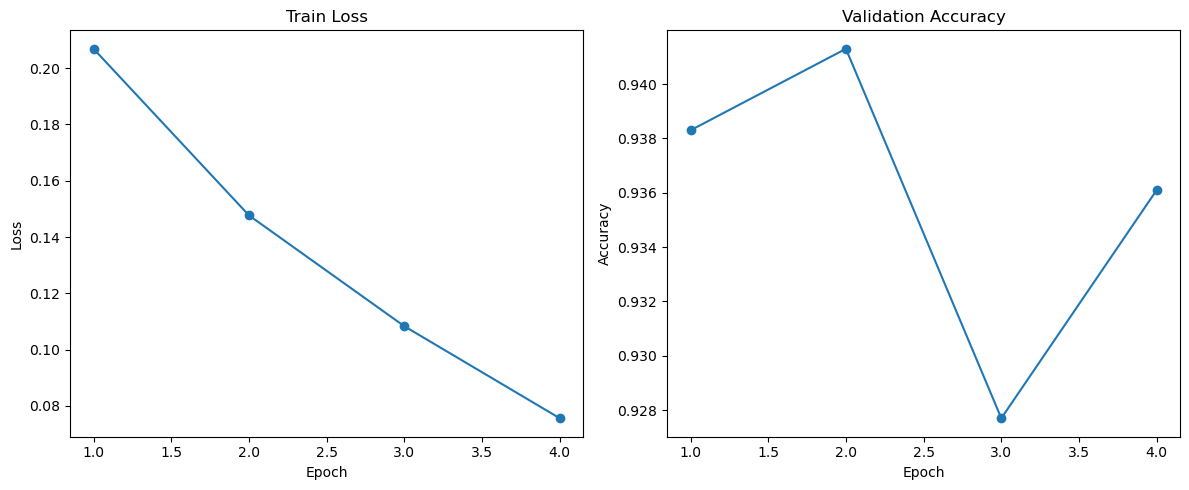

In [8]:
import matplotlib.pyplot as plt

train_losses = [0.2069, 0.1477, 0.1083, 0.0756]
val_accuracies = [0.9383, 0.9413, 0.9277, 0.9361]

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12,5))

# Train Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Validation Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()

output_dir = "../outputs/"

plt.savefig(os.path.join(output_dir, "training_plot.png"))

plt.show()

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

MODEL_DIR = "../models/best_bert_model"

tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
model = BertForSequenceClassification.from_pretrained(MODEL_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Model loaded successfully! Device = {device}")

# Prediction function
label_map = {0: "negative", 1: "positive"}

def predict(text):
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1).item()

    return {
        "text": text,
        "prediction": label_map[pred_label],
        "confidence": float(torch.max(probs).item())
    }

# Example usage
examples = [
    "ürün çok kötüydü bir daha almam",
    "mükemmel hizmet tekrar sipariş veririm",
    "ortalama bir deneyimdi",
    "yemek çok güzeldi, servis hızlıydı",
    "Servis mükemmeldi ama sipariş soğuktu, tam bir hayal kırıklığı.",
    "Fiyatlar uygun, ortam güzeldi ama balıklar pek taze değildi.",
    "Mekanın dekoru harika, yemekler sıradan ve tatsızdı.",
    "Fiyat-performans çok iyiydi, kesinlikle tavsiye ederim.",
    "Yemekler sıcaktı ve tam istediğimiz gibi geldi, çok memnun kaldık.",
    "Yemekler çok kötüydü ama servis iyiydi."
]

print("\n--- PREDICTIONS ---")
for e in examples:
    print(predict(e))


Model loaded successfully! Device = cpu

--- PREDICTIONS ---
{'text': 'ürün çok kötüydü bir daha almam', 'prediction': 'negative', 'confidence': 0.9981644749641418}
{'text': 'mükemmel hizmet tekrar sipariş veririm', 'prediction': 'positive', 'confidence': 0.9987595081329346}
{'text': 'ortalama bir deneyimdi', 'prediction': 'negative', 'confidence': 0.9910985827445984}
{'text': 'yemek çok güzeldi, servis hızlıydı', 'prediction': 'positive', 'confidence': 0.9962051510810852}
{'text': 'Servis mükemmeldi ama sipariş soğuktu, tam bir hayal kırıklığı.', 'prediction': 'negative', 'confidence': 0.9862727522850037}
{'text': 'Fiyatlar uygun, ortam güzeldi ama balıklar pek taze değildi.', 'prediction': 'negative', 'confidence': 0.8360291719436646}
{'text': 'Mekanın dekoru harika, yemekler sıradan ve tatsızdı.', 'prediction': 'negative', 'confidence': 0.8713088631629944}
{'text': 'Fiyat-performans çok iyiydi, kesinlikle tavsiye ederim.', 'prediction': 'positive', 'confidence': 0.9979315996170044}
